# Big G Express Predictive Models

## Imports

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from my_functions import create_target_window, stratifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, RocCurveDisplay, roc_auc_score, roc_curve
import pickle

In [153]:
def train_test_val_split(X, y, trucks = False):
    X_strat = stratifier(X, trucks)
    y_strat = stratifier(y, trucks)
    X_train = X_strat.loc[X_strat['train_test_val']=='train', X_strat.drop(columns = ['EventTimeStamp', 'train_test_val', 'EquipmentID']).columns]
    y_train = y_strat.loc[y_strat['train_test_val']=='train', 'target']
    X_test = X_strat.loc[X_strat['train_test_val']=='test', X_strat.drop(columns = ['EventTimeStamp', 'train_test_val', 'EquipmentID']).columns]
    y_test = y_strat.loc[y_strat['train_test_val']=='test', 'target']
    X_val = X_strat.loc[X_strat['train_test_val']=='val', X_strat.drop(columns = ['EventTimeStamp', 'train_test_val', 'EquipmentID']).columns]
    y_val = y_strat.loc[y_strat['train_test_val']=='val', 'target']
    return X_train, y_train, X_test, y_test, X_val, y_val

In [154]:
def cost_scorer(y_test, y_pred, cost_fp = 1.0, cost_fn = 1.0):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return (cost_fp*fp) + (cost_fn*fn)

## Read ins

In [155]:
faults = pd.read_pickle('../data/faults_df.pickle')
diag = pd.read_pickle('../data/diag_df.pickle')
fdwide = pd.read_pickle('../data/fdwide_df.pickle')

In [156]:
stratifier(y)

,EventTimeStamp,target,train_test_val
2,2015-05-10 07:11:34,False,train
4,2015-05-11 13:11:20,False,train
6,2015-05-13 08:22:32,False,train
8,2015-05-18 09:34:05,False,train
11,2015-05-21 13:57:35,False,train
...,...,...,...
1187325,2018-09-06 00:34:32,False,validation
1187327,2015-02-24 13:45:06,False,train
1187328,2015-02-24 15:31:17,False,train
1187331,2015-02-26 13:12:11,False,train


## First Model

First, let's make a simple, scaled logistic regression model based on one of our important features, *FuelLtd*. Some notes:
- Target window hours are set to 120 (5 days). We're allowing a lot of noise for this first run and will most likely shorten this window later.
- Until I clean up my functions, EventTimeStamp and EquipmentID to be in both X and y for the custom train-test-validation split.
- We'll consider trucks in the stratification.

In [157]:
df = create_target_window(fdwide, both_derate_types=False, target_window_hours=120)
df_selected = df[['EventTimeStamp', 'EquipmentID', 'FuelLtd', 'target']].dropna()

X = df_selected[['EventTimeStamp', 'EquipmentID', 'FuelLtd']]
y = df_selected[['EventTimeStamp', 'EquipmentID','target']]

X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y, trucks = True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
fuel_test_probs = pipeline.predict_proba(X_test)

As shown below, this model simply predicts no derate for every point, which is typical when predicting faults (rare events)

In [158]:
print("f1_score: ", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(pd.Series(np.split(fuel_test_probs,2,axis=1)[1].flatten()).describe())

f1_score:  0.0
[[115355      0]
 [  1285      0]]
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    115355
        True       0.00      0.00      0.00      1285

    accuracy                           0.99    116640
   macro avg       0.49      0.50      0.50    116640
weighted avg       0.98      0.99      0.98    116640

count    116640.000000
mean          0.007685
std           0.001573
min           0.005153
25%           0.006777
50%           0.007891
75%           0.008429
max           0.042919
dtype: float64


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The ROC curve below is pretty awful, though there is a point near the top right where the curve jumps up past the reference line.

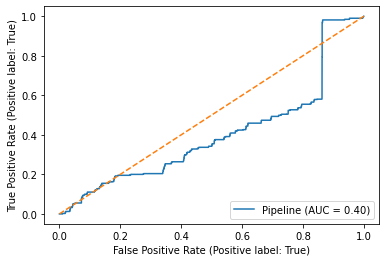

In [159]:
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.plot([0,1], [0,1], '--');

In our particular question, it's most important that we minimize total costs. Here, we check the total costs for each threshold on a 0.1 interval from 0 to 1. It looks like at some point between 0 and 0.1, there's a point where our regression only predicts a False. (That's likely also where our ROC makes a leap.)

In [160]:
threshold_range = np.arange(0, 1.1, 0.1)
costs = {t: cost_scorer(y_test, [p[1] > t for p in fuel_test_probs], cost_fp=1200, cost_fn=5000) for t in threshold_range}
costs

{0.0: 138426000,
 0.1: 6425000,
 0.2: 6425000,
 0.30000000000000004: 6425000,
 0.4: 6425000,
 0.5: 6425000,
 0.6000000000000001: 6425000,
 0.7000000000000001: 6425000,
 0.8: 6425000,
 0.9: 6425000,
 1.0: 6425000}

### Let's experiment with looping this basic model for different target window times
We're using the same setup as above; however, now we're building a larger dictionary for a variety of target windows from 3 hours to 5 days

In [161]:
windows = np.concatenate([np.arange(3, 27, 3), np.arange(36, 121, 12)])
costs_dict = {}
for window in windows:
    df = create_target_window(fdwide, both_derate_types=False, target_window_hours=float(window))
    df_selected = df[['EventTimeStamp', 'EquipmentID', 'FuelLtd', 'target']].dropna()

    X = df_selected[['EventTimeStamp', 'EquipmentID', 'FuelLtd']]
    y = df_selected[['EventTimeStamp', 'EquipmentID','target']]

    X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y, trucks = True)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    fuel_test_probs = pipeline.predict_proba(X_test)

    threshold_range = np.arange(0, 1.1, 0.1)
    costs_dict[f"{window} hours"] = {t: cost_scorer(y_test, [p[1] > t for p in fuel_test_probs], cost_fp=1200, cost_fn=5000) for t in threshold_range}

Collecting these results into a dataframe, we see that the minimum cost for each window occurs at the 0.1 threshold; however, the 3-hour target introduces the lowest costs.

In [162]:
costs_df = (pd.DataFrame.from_dict(costs_dict, orient='index')
        .reset_index()
        .melt(id_vars='index', 
              var_name='threshold', 
              value_name='cost')
        .rename(columns = {'index': 'target_window'})
    )
(costs_df.sort_values(['cost', 'threshold'])
         .drop_duplicates(subset = ['target_window', 'cost'])
         .reset_index(drop = True)
         .head(10)
)

,target_window,threshold,cost
0,3 hours,0.1,1135000
1,6 hours,0.1,1435000
2,9 hours,0.1,1575000
3,12 hours,0.1,2780000
4,15 hours,0.1,3095000
5,18 hours,0.1,3260000
6,21 hours,0.1,3390000
7,24 hours,0.1,3485000
8,36 hours,0.1,4875000
9,48 hours,0.1,5050000


### As a last step with this simple model, let's look at all the reporting content with the target window and threshold optimized.
So we're setting the window to 3 and the threshold to 0.1 (though we'll explore this a little, too).

In [163]:
df = create_target_window(fdwide, both_derate_types=False, target_window_hours=3)
df_selected = df[['EventTimeStamp', 'EquipmentID', 'FuelLtd', 'target']].dropna()

X = df_selected[['EventTimeStamp', 'EquipmentID', 'FuelLtd']]
y = df_selected[['EventTimeStamp', 'EquipmentID','target']]

X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(X, y, trucks = True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
fuel_test_probs = pipeline.predict_proba(X_test)

Confirmed: Our optimal threshold is just the first threshold that never predicts a derate. There's some tension here, then, in whether to prioritize optimizing total costs or the f1 score. Most likely the total costs are the most important. We might just need some more features.

confusion matrix:
 [[     0 116413]
 [     0    227]]
False Positives:  116413 
False Negatives:  0
f1 score:  0.0038847578871708866
Total Cost:  $139,695,600.00
              precision    recall  f1-score   support

       False       0.00      0.00      0.00    116413
        True       0.00      1.00      0.00       227

    accuracy                           0.00    116640
   macro avg       0.00      0.50      0.00    116640
weighted avg       0.00      0.00      0.00    116640

Threshold value is: 2


C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


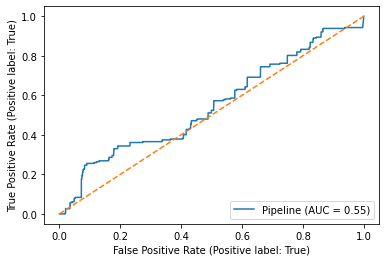

In [192]:
t = 0
preds = [p[1] > t for p in fuel_test_probs]
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print("confusion matrix:\n", confusion_matrix(y_test, preds))
print("False Positives: ", fp, "\nFalse Negatives: ", fn)
print("f1 score: ", f1_score(y_test, preds))
print("Total Cost: ",  "${:,.2f}".format(cost_scorer(y_test, preds, cost_fp=1200, cost_fn=5000)))
print(classification_report(y_test, preds))

fpr, tpr, thresholds = roc_curve(y_test, preds)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.plot([0,1], [0,1], '--');


## Let's try including the spn and fmi columns

In [165]:
# df = create_target_window(fdwide, both_derate_types=False, target_window_hours=36)
# df_selected = df[['FuelLtd', 'spn', 'fmi', 'target']].dropna()

# X = df_selected[['FuelLtd']]
# y = df_selected[['target']]

# X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split

# ct = ColumnTransformer([
#             ('ohe', OneHotEncoder(sparse = False, drop = 'first'), catcols)
#         ],
#         remainder="passthrough"
#     )

# pipeline = Pipeline([
#     ('ct', ct),
#     ('scaler', StandardScaler()),
#     ('logreg', LogisticRegression())
# ])

# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# print("f1_score: ", f1_score(y_test_ y_pred))
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test_y_pred))

## Appendix

In [166]:
dropcols = ['RecordID','actionDescription','ESS_Id','eventDescription', 'ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 'ecuMake', 'ecuSource', 
            'faultValue', 'EquipmentID', 'MCTNumber', 'LocationTimeStamp', 'eventGroup', 'FaultId', 'EventTimeStamp', 'ParkingBrake', 'ServiceDistance',
            'SwitchedBatteryVoltage', 'FuelTemperature', 'Throttle', 'spn-fmi']
catcols = ['spn', 'fmi', 'LampStatus']
# X = df.assign(timeTillLast = df['timeTillLast'].dt.total_seconds()).drop(columns = dropcols).dropna()
# X.shape